In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [14]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [15]:
class DNN_10(nn.Module):
    def __init__(self, input_dim):
        super(DNN_10, self).__init__()
        self.layer1 = nn.Linear(input_dim,128)
        self.layer2 = nn.Linear(128,64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 16)

        self.output_layer=nn.Linear(16,1)
        
        
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        
        x = torch.relu(self.layer2(x))
        
        x = torch.relu(self.layer3(x))
        
        x = torch.relu(self.layer4(x))

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [16]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=4, shuffle=False)

Optunaの設定

In [17]:
def objective(trial):
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整

    # モデル定義
    model = DNN_10(
        input_dim=X_train_tensor.shape[1]).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >= 0.5).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stoppingの判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 評価指標の計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [18]:
device_id = 0  # 使用するGPUのID（0または1）
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-04 16:36:04,557] A new study created in memory with name: no-name-dcf2e4f4-9f40-4dc5-bd85-ca5f1a48bdec
/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:40:04,862] Trial 0 finished with value: 0.28195567008791605 and parameters: {'learning_rate': 0.00018510022181341364, 'weight_decay': 0.004333140743882166}. Best is trial 0 with value: 0.28195567008791605.


Early stopping at epoch 65
Final MCC: 0.2820


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:42:00,248] Trial 1 finished with value: 0.25849832497249015 and parameters: {'learning_rate': 0.0005298029356470835, 'weight_decay': 0.00039263013521765114}. Best is trial 0 with value: 0.28195567008791605.


Early stopping at epoch 31
Final MCC: 0.2585


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:43:47,312] Trial 2 finished with value: 0.29685993184495857 and parameters: {'learning_rate': 0.0003130827516245242, 'weight_decay': 0.003375535689179423}. Best is trial 2 with value: 0.29685993184495857.


Early stopping at epoch 29
Final MCC: 0.2969


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:48:03,470] Trial 3 finished with value: 0.2645751311064591 and parameters: {'learning_rate': 0.00011297941771621844, 'weight_decay': 0.0016057773622017285}. Best is trial 2 with value: 0.29685993184495857.


Early stopping at epoch 71
Final MCC: 0.2646


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:49:54,299] Trial 4 finished with value: 0.3045662781080955 and parameters: {'learning_rate': 0.00023246730965833666, 'weight_decay': 0.003469975155143777}. Best is trial 4 with value: 0.3045662781080955.


Early stopping at epoch 30
Final MCC: 0.3046


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:49:57,909] Trial 5 pruned. 
[I 2024-12-04 16:50:01,601] Trial 6 pruned. 
[I 2024-12-04 16:50:05,214] Trial 7 pruned. 
[I 2024-12-04 16:50:08,824] Trial 8 pruned. 
[I 2024-12-04 16:52:50,225] Trial 9 finished with value: 0.32882073813868984 and parameters: {'learning_rate': 0.0012618353814914398, 'weight_decay': 0.0006914925225587698

Early stopping at epoch 43
Final MCC: 0.3288


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:52:54,010] Trial 10 pruned. 
[I 2024-12-04 16:54:26,459] Trial 11 finished with value: 0.0 and parameters: {'learning_rate': 0.0015098676132426004, 'weight_decay': 0.0012350093219860637}. Best is trial 9 with value: 0.32882073813868984.


Early stopping at epoch 24
Final MCC: 0.0000


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:54:30,148] Trial 12 pruned. 
[I 2024-12-04 16:56:08,929] Trial 13 finished with value: 0.31649513887630376 and parameters: {'learning_rate': 0.0008331655036031765, 'weight_decay': 0.0008704193477292166}. Best is trial 9 with value: 0.32882073813868984.


Early stopping at epoch 26
Final MCC: 0.3165


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:56:12,560] Trial 14 pruned. 
[I 2024-12-04 16:56:16,228] Trial 15 pruned. 
[I 2024-12-04 16:56:19,879] Trial 16 pruned. 
[I 2024-12-04 16:56:23,527] Trial 17 pruned. 
[I 2024-12-04 16:56:27,181] Trial 18 pruned. 
[I 2024-12-04 16:56:30,799] Trial 19 pruned. 
[I 2024-12-04 16:56:34,437] Trial 20 pruned. 
[I 2024-12-04 16:59:34,810] T

Early stopping at epoch 48
Final MCC: 0.3007


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 16:59:38,336] Trial 22 pruned. 
[I 2024-12-04 16:59:41,838] Trial 23 pruned. 
[I 2024-12-04 16:59:45,326] Trial 24 pruned. 
[I 2024-12-04 16:59:48,904] Trial 25 pruned. 
[I 2024-12-04 16:59:52,482] Trial 26 pruned. 
[I 2024-12-04 17:01:46,178] Trial 27 finished with value: 0.15635070158909536 and parameters: {'learning_rate': 0.0001915

Early stopping at epoch 30
Final MCC: 0.1564


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:01:49,920] Trial 28 pruned. 
[I 2024-12-04 17:01:53,675] Trial 29 pruned. 
[I 2024-12-04 17:01:57,429] Trial 30 pruned. 
[I 2024-12-04 17:04:34,075] Trial 31 finished with value: 0.2678648032030917 and parameters: {'learning_rate': 0.00011405012711529742, 'weight_decay': 0.009918705284724199}. Best is trial 9 with value: 0.328820738

Early stopping at epoch 41
Final MCC: 0.2679


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:06:44,233] Trial 32 finished with value: 0.2946096069503197 and parameters: {'learning_rate': 0.0001399086720693898, 'weight_decay': 0.006314697080729412}. Best is trial 9 with value: 0.32882073813868984.


Early stopping at epoch 34
Final MCC: 0.2946


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:06:47,979] Trial 33 pruned. 
[I 2024-12-04 17:09:52,320] Trial 34 finished with value: 0.29072133077420836 and parameters: {'learning_rate': 0.0001011855317695384, 'weight_decay': 0.0032875130243747584}. Best is trial 9 with value: 0.32882073813868984.


Early stopping at epoch 51
Final MCC: 0.2907


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:12:37,525] Trial 35 finished with value: 0.3276033597166953 and parameters: {'learning_rate': 0.0002756039890292162, 'weight_decay': 0.0013650032309659988}. Best is trial 9 with value: 0.32882073813868984.


Early stopping at epoch 49
Final MCC: 0.3276


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:12:40,904] Trial 36 pruned. 
[I 2024-12-04 17:12:44,351] Trial 37 pruned. 
[I 2024-12-04 17:12:47,757] Trial 38 pruned. 
[I 2024-12-04 17:12:51,239] Trial 39 pruned. 
[I 2024-12-04 17:12:54,635] Trial 40 pruned. 
[I 2024-12-04 17:14:37,438] Trial 41 finished with value: 0.2956695465288894 and parameters: {'learning_rate': 0.00013115

Early stopping at epoch 31
Final MCC: 0.2957


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:14:40,413] Trial 42 pruned. 
[I 2024-12-04 17:16:56,599] Trial 43 finished with value: 0.19088761429254134 and parameters: {'learning_rate': 0.00013948636063592181, 'weight_decay': 0.0011964166243450855}. Best is trial 9 with value: 0.32882073813868984.


Early stopping at epoch 45
Final MCC: 0.1909


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:16:59,620] Trial 44 pruned. 
[I 2024-12-04 17:17:02,587] Trial 45 pruned. 
[I 2024-12-04 17:17:05,593] Trial 46 pruned. 
[I 2024-12-04 17:18:40,684] Trial 47 finished with value: 0.0 and parameters: {'learning_rate': 0.008474122381961081, 'weight_decay': 0.000990019774678551}. Best is trial 9 with value: 0.32882073813868984.


Early stopping at epoch 31
Final MCC: 0.0000


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:18:43,662] Trial 48 pruned. 
[I 2024-12-04 17:18:46,637] Trial 49 pruned. 
[I 2024-12-04 17:20:28,062] Trial 50 finished with value: 0.30348848933344197 and parameters: {'learning_rate': 0.0001557586919456737, 'weight_decay': 0.0015535374288027579}. Best is trial 9 with value: 0.32882073813868984.


Early stopping at epoch 33
Final MCC: 0.3035


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:22:59,586] Trial 51 finished with value: 0.2535772325601047 and parameters: {'learning_rate': 0.00016668308242616503, 'weight_decay': 0.0016225172857749705}. Best is trial 9 with value: 0.32882073813868984.


Early stopping at epoch 50
Final MCC: 0.2536


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:23:02,582] Trial 52 pruned. 
[I 2024-12-04 17:23:05,553] Trial 53 pruned. 
[I 2024-12-04 17:23:08,521] Trial 54 pruned. 
[I 2024-12-04 17:23:11,513] Trial 55 pruned. 
[I 2024-12-04 17:24:55,600] Trial 56 finished with value: 0.3183000707900252 and parameters: {'learning_rate': 0.00010164096930594467, 'weight_decay': 0.00215994280130

Early stopping at epoch 34
Final MCC: 0.3183


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:24:58,596] Trial 57 pruned. 
[I 2024-12-04 17:25:01,589] Trial 58 pruned. 
[I 2024-12-04 17:25:04,606] Trial 59 pruned. 
[I 2024-12-04 17:25:07,613] Trial 60 pruned. 
[I 2024-12-04 17:25:10,594] Trial 61 pruned. 
[I 2024-12-04 17:25:13,629] Trial 62 pruned. 
[I 2024-12-04 17:30:06,132] Trial 63 finished with value: 0.272478296212182

Early stopping at epoch 96
Final MCC: 0.2725


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:30:09,183] Trial 64 pruned. 
[I 2024-12-04 17:30:12,214] Trial 65 pruned. 
[I 2024-12-04 17:30:15,290] Trial 66 pruned. 
[I 2024-12-04 17:30:18,332] Trial 67 pruned. 
[I 2024-12-04 17:32:36,999] Trial 68 finished with value: 0.3007160357898652 and parameters: {'learning_rate': 0.000122443189199431, 'weight_decay': 0.0055350371139481

Early stopping at epoch 45
Final MCC: 0.3007


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:32:39,997] Trial 69 pruned. 
[I 2024-12-04 17:33:49,990] Trial 70 finished with value: 0.2904818397905802 and parameters: {'learning_rate': 0.0022114536636227795, 'weight_decay': 0.0036731356739885365}. Best is trial 9 with value: 0.32882073813868984.


Early stopping at epoch 24
Final MCC: 0.2905


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:36:36,184] Trial 71 finished with value: 0.29072133077420836 and parameters: {'learning_rate': 0.00011034989824216662, 'weight_decay': 0.005510718655159179}. Best is trial 9 with value: 0.32882073813868984.


Early stopping at epoch 60
Final MCC: 0.2907


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:36:38,840] Trial 72 pruned. 
[I 2024-12-04 17:36:41,437] Trial 73 pruned. 
[I 2024-12-04 17:36:44,022] Trial 74 pruned. 
[I 2024-12-04 17:36:46,594] Trial 75 pruned. 
[I 2024-12-04 17:38:07,727] Trial 76 finished with value: 0.0 and parameters: {'learning_rate': 0.009908980816349586, 'weight_decay': 0.0015842620985827083}. Best is t

Early stopping at epoch 30
Final MCC: 0.0000


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:40:04,506] Trial 77 finished with value: 0.2172834164659464 and parameters: {'learning_rate': 0.00010104335961894153, 'weight_decay': 0.005773001564475738}. Best is trial 9 with value: 0.32882073813868984.


Early stopping at epoch 43
Final MCC: 0.2173


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:40:07,330] Trial 78 pruned. 
[I 2024-12-04 17:40:10,048] Trial 79 pruned. 
[I 2024-12-04 17:40:12,720] Trial 80 pruned. 
[I 2024-12-04 17:40:15,399] Trial 81 pruned. 
[I 2024-12-04 17:40:18,139] Trial 82 pruned. 
[I 2024-12-04 17:40:20,905] Trial 83 pruned. 
[I 2024-12-04 17:40:23,643] Trial 84 pruned. 
[I 2024-12-04 17:42:17,520] T

Early stopping at epoch 42
Final MCC: 0.2957


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:42:20,179] Trial 86 pruned. 
[I 2024-12-04 17:42:22,922] Trial 87 pruned. 
[I 2024-12-04 17:42:25,551] Trial 88 pruned. 
[I 2024-12-04 17:42:28,151] Trial 89 pruned. 
[I 2024-12-04 17:42:30,651] Trial 90 pruned. 
[I 2024-12-04 17:42:33,280] Trial 91 pruned. 
[I 2024-12-04 17:45:14,260] Trial 92 finished with value: 0.206319091621613

Early stopping at epoch 60
Final MCC: 0.2063


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:45:16,825] Trial 93 pruned. 
[I 2024-12-04 17:48:17,517] Trial 94 finished with value: 0.2771739468734333 and parameters: {'learning_rate': 0.00016287489038922047, 'weight_decay': 0.0064287543324691955}. Best is trial 9 with value: 0.32882073813868984.


Early stopping at epoch 68
Final MCC: 0.2772


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:50:44,633] Trial 95 finished with value: 0.27510921178155795 and parameters: {'learning_rate': 0.00011239543589471981, 'weight_decay': 0.002019179108108038}. Best is trial 9 with value: 0.32882073813868984.


Early stopping at epoch 55
Final MCC: 0.2751


/tmp/ipykernel_282705/1190680174.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)  # 範囲を調整
/tmp/ipykernel_282705/1190680174.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   # 範囲を調整
[I 2024-12-04 17:50:47,282] Trial 96 pruned. 
[I 2024-12-04 17:50:49,873] Trial 97 pruned. 
[I 2024-12-04 17:50:52,499] Trial 98 pruned. 
[I 2024-12-04 17:50:55,077] Trial 99 pruned. 


Best Parameters:  {'learning_rate': 0.0012618353814914398, 'weight_decay': 0.0006914925225587698}
Best Validation F1:  0.32882073813868984


Epoch [1/100], Loss: 0.5857
Epoch [1/100], Train Loss: 0.5857, Val Loss: 0.5698
Epoch [2/100], Loss: 0.5665
Epoch [2/100], Train Loss: 0.5665, Val Loss: 0.5695
Epoch [3/100], Loss: 0.5654
Epoch [3/100], Train Loss: 0.5654, Val Loss: 0.5640
Epoch [4/100], Loss: 0.5643
Epoch [4/100], Train Loss: 0.5643, Val Loss: 0.5628
Epoch [5/100], Loss: 0.5599
Epoch [5/100], Train Loss: 0.5599, Val Loss: 0.5789
Epoch [6/100], Loss: 0.5599
Epoch [6/100], Train Loss: 0.5599, Val Loss: 0.5662
Epoch [7/100], Loss: 0.5622
Epoch [7/100], Train Loss: 0.5622, Val Loss: 0.5680
Epoch [8/100], Loss: 0.5607
Epoch [8/100], Train Loss: 0.5607, Val Loss: 0.5652
Epoch [9/100], Loss: 0.5603
Epoch [9/100], Train Loss: 0.5603, Val Loss: 0.5624
Epoch [10/100], Loss: 0.5611
Epoch [10/100], Train Loss: 0.5611, Val Loss: 0.5654
Epoch [11/100], Loss: 0.5572
Epoch [11/100], Train Loss: 0.5572, Val Loss: 0.5650
Epoch [12/100], Loss: 0.5584
Epoch [12/100], Train Loss: 0.5584, Val Loss: 0.5679
Epoch [13/100], Loss: 0.5573
Epoch

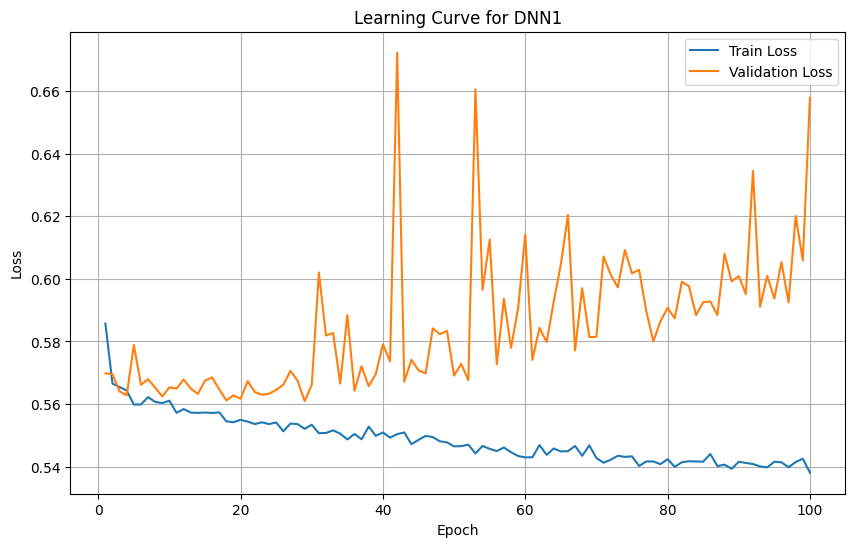

In [19]:
best_params=study.best_params
model = DNN_10(input_dim=X_train_tensor.shape[1]).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN1')
plt.legend()
plt.grid()
plt.show()

Accuracy: 56.72%
Precision: 0.4676
Recall: 0.8732
F1 Score: 0.6091
Matthews Correlation Coefficient: 0.2691
Specificity: 0.3748


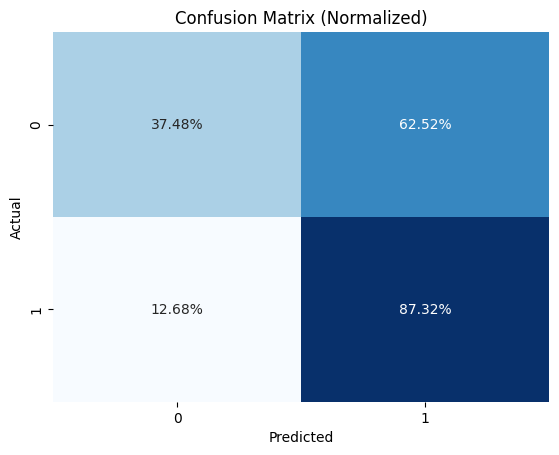

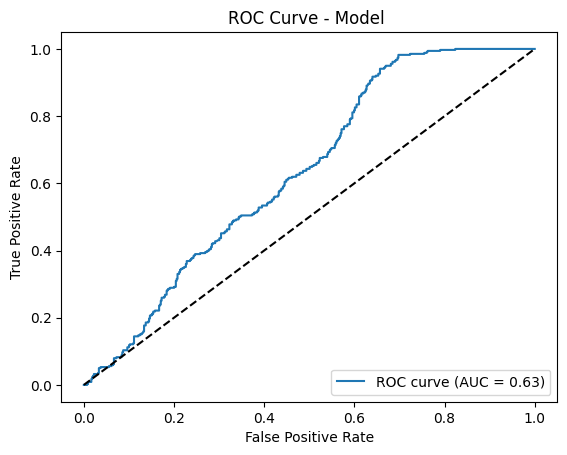

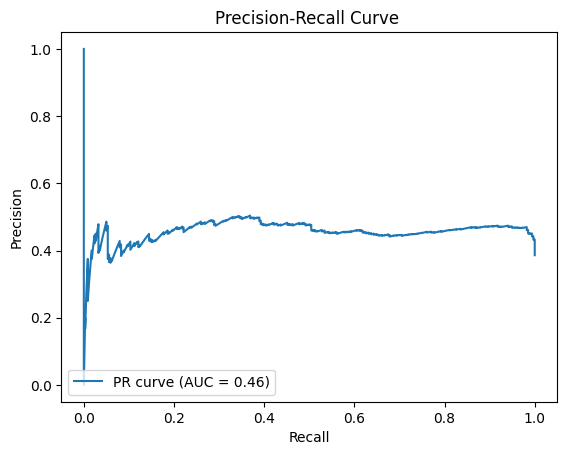

In [20]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >0.49).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [21]:
# モデルと構造を保存
torch.save(model.state_dict(), '../../saved_model/DNN_10.pth')

